In [528]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl



In [529]:
sns.set_style("darkgrid")
sns.set_palette("Paired")
sns.set_context("notebook")
pd.options.display.max_rows = 200

%config InlineBackend.figure_format='retina'


In [530]:
def plotJobSatisfaction(column,width = 5, height = 5, bartype = 'bar'):
    props = survey_dev.groupby(column)['JobSat'].value_counts(normalize=True).unstack()
    props.plot(kind= bartype, stacked='True', figsize = (width,height))
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");

The original dataset contains 85 columns, mostly categorical. My goal in this notebook is to investigate which factors contribute to a developer's job satisfaction. With this in mind, I think that only some of the original 85 columns are actually relevant to our analysis. To avoid cluttering the notebook, I already excluded the features that I don't want to investigate further, such as the developer's learning goals for 2020 and some personal information like sexuality and ethnicity - though I decided to keep the *Gender* column.

The survey includes both a column for "Career Satisfaction" and one for "Job Satisfaction". I've decided to focus on analyzing on **job satisfaction** out of the two.

## Importing data and initial analysis

In [531]:
survey_raw = pd.read_csv("data/survey_results_public_reduced.csv", header = 0, sep = ';', encoding = 'ISO 8859-1')

In [532]:
survey_raw.head()

,MainBranch,Hobbyist,OpenSourcer,Employment,Country,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,...,JobSat,MgrWant,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,ImpSyn,Age,Gender
0,I am a student who is learning to code,Yes,Never,"Not employed, and not looking for work",United Kingdom,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,Man
1,I am a student who is learning to code,No,Less than once per year,"Not employed, but looking for work",Bosnia and Herzegovina,"Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,Man
2,"I am not primarily a developer, but I write co...",Yes,Never,Employed full-time,Thailand,"Bachelors degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",...,Slightly satisfied,Not sure,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never,Average,28.0,Man
3,I am a developer by profession,No,Never,Employed full-time,United States,"Bachelors degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,100 to 499 employees,"Developer, full-stack",...,Slightly satisfied,Not sure,61000.0,80.0,There's no schedule or spec; I work on what se...,NaN,Less than once per month / Never,A little below average,22.0,Man
4,I am a developer by profession,Yes,Once a month or more often,Employed full-time,Ukraine,"Bachelors degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,"10,000 or more employees","Academic researcher;Developer, desktop or ente...",...,Slightly dissatisfied,No,NaN,55.0,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,A few days each month,A little above average,30.0,Man


You'll notice that in its raw form the dataset is not suitable to build a ML model, since most of the answers are categorical. Those fields will have to be properly encoded before a model can extract any insight from this data. 

We can stick to the predefined fields for the exploratory analysis phase.

In [533]:
print(survey_raw.columns)
print(survey_raw.info(verbose = False))

Index(['MainBranch', 'Hobbyist', 'OpenSourcer', 'Employment', 'Country',
       'EdLevel', 'UndergradMajor', 'EduOther', 'OrgSize', 'DevType',
       'YearsCode', 'YearsCodePro', 'CareerSat', 'JobSat', 'MgrWant',
       'ConvertedComp', 'WorkWeekHrs', 'WorkPlan', 'WorkChallenge',
       'WorkRemote', 'ImpSyn', 'Age', 'Gender'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88883 entries, 0 to 88882
Columns: 23 entries, MainBranch to Gender
dtypes: float64(3), object(20)
memory usage: 15.6+ MB
None


As we can see, the dataset contains almost 90000 answers to the survey. However, **not all survey takers were developers**: the survey also includes student, ex-devs and other categories. To figure out how many of these answers are from working developers, we can look at the *MainBranch* column.

In [534]:
# numeric columns
survey_raw.select_dtypes(include=[float,int]).columns

Index(['ConvertedComp', 'WorkWeekHrs', 'Age'], dtype='object')

Some fields should be numeric but are now classified as object, because these fields have some text answers, like "Less than 1 year" for the "Years as a professional coder" field. We'll deal with this issue later.

#### Selecting data of interest

I will remove from the dataset:
- People who are not currently developers (e.g. student, ex devs)
- Part-time developers
- Answers from developer with less than 1 year of coding experience (included outside of work)

This will have the added advantage of making the "YearsCode" column entirely numerical.

In [535]:
# only prof. developers
survey_dev = survey_raw[(survey_raw['MainBranch'] == 'I am a developer by profession')]

# exclude part time
survey_dev = survey_dev[(survey_dev['Employment'] == 'Employed full-time')
| (survey_dev['Employment'] == 'Independent contractor, freelancer, or self-employed') ]

# exclude less than 1 year coding
survey_dev = survey_dev[(survey_dev['YearsCodePro'] != 'Less than 1 year')]


In [536]:
survey_dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59009 entries, 4 to 88330
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MainBranch      59009 non-null  object 
 1   Hobbyist        59009 non-null  object 
 2   OpenSourcer     59009 non-null  object 
 3   Employment      59009 non-null  object 
 4   Country         59009 non-null  object 
 5   EdLevel         57994 non-null  object 
 6   UndergradMajor  54586 non-null  object 
 7   EduOther        56528 non-null  object 
 8   OrgSize         57572 non-null  object 
 9   DevType         58480 non-null  object 
 10  YearsCode       58637 non-null  object 
 11  YearsCodePro    58547 non-null  object 
 12  CareerSat       59009 non-null  object 
 13  JobSat          58745 non-null  object 
 14  MgrWant         49345 non-null  object 
 15  ConvertedComp   46709 non-null  float64
 16  WorkWeekHrs     53696 non-null  float64
 17  WorkPlan        57093 non-null 

We're down to about **60000 rows**. Also, since Job Satisfaction is out target variable, it's best to drop the rows for which it's null - they're just a few hundred.

In [537]:
survey_dev = survey_dev[survey_dev.JobSat.notnull()]
len(survey_dev)

58745

## Exploratory data analysis

First of all, I'd like to know the distribution of our target variable - Job Satisfaction. It will be useful to know if our dataset is balanced enough.

In [538]:
survey_dev['JobSat'].value_counts()

Slightly satisfied                    20147
Very satisfied                        18549
Slightly dissatisfied                  8882
Neither satisfied nor dissatisfied     7128
Very dissatisfied                      4039
Name: JobSat, dtype: int64

Seems like our survery data is skewed towards higher job satisfaction: about 66% of the respondents are satisfied with their career, and about 22% report being slightly or very dissatisfied. The rest are in the middle of the scale.
For the machine learning model I want to use a binary target variable, so I will split the answers in 'Satisfied' (which includes only the fisrt two answers) and 'Not Satisfied'.

In [539]:
sat =  ['Very satisfied', 'Slightly satisfied']

survey_dev['Target'] = survey_dev['JobSat'].map({'Very satisfied':1, 'Slightly satisfied':1}).fillna(0)


### Demographics

#### Country

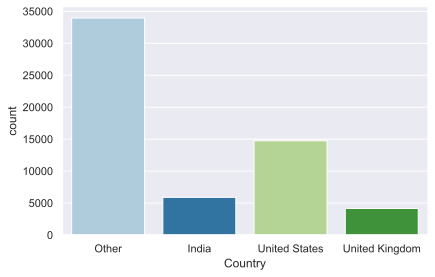

In [540]:
# Country 
survey_dev['CountryCat'] = survey_dev['Country']
survey_dev['CountryCat'] = np.where(((survey_dev['Country'] != 'United States') 
                                     & (survey_dev['Country'] != 'United Kingdom')
                                     & (survey_dev['Country'] != 'India'))
                                    , 'Other', survey_dev['Country'])
sns.catplot(x="CountryCat", kind="count", data=survey_dev, aspect = 1.5, height = 4)
plt.xlabel('Country');

Let's start off with a tricky one. As you see, the majority of respondents actually aren't from the United States or UK. India is very well represented, along with other countries all over the world.
The reason this makes the analysis tricky is that it basically stops us from using the *Compensation* column as a feature for the model. Even though the compensation has been converted to US dollars for all survey respondents, it cannot give us any reliable information since the same amount of money will lead to wildly different purchasing powers in different countries.

So, I will remove the compensation column now.

In [541]:
survey_dev = survey_dev.drop(['ConvertedComp', 'CountryCat'],axis = 1)

#### Age

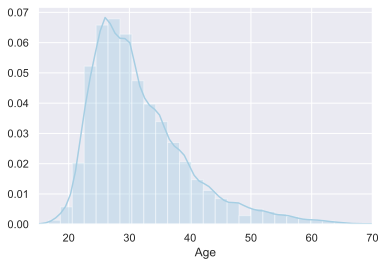

In [542]:
#Age
sns.distplot(survey_dev['Age'])
plt.xlim(15, 70);


#### Gender

In [543]:
#Gender
print(survey_dev['Gender'].value_counts() )

print('\nNumber of NULL gender values: ' + str(survey_dev['Gender'].isnull().sum()))

man_p = 100*(len(survey_dev[survey_dev['Gender'] == 'Man']) / len(survey_dev))
print('Percentage of developers who identify as men: ' + str(np.round(man_p,2)) + '%')


Man                                                            52673
Woman                                                           3664
Non-binary, genderqueer, or gender non-conforming                342
Man;Non-binary, genderqueer, or gender non-conforming            106
Woman;Non-binary, genderqueer, or gender non-conforming           84
Woman;Man                                                         50
Woman;Man;Non-binary, genderqueer, or gender non-conforming       30
Name: Gender, dtype: int64

Number of NULL gender values: 1796
Percentage of developers who identify as men: 89.66%


I don't want to remove the takers who identified as something other than Man or Woman, but to simplify the analysis I'm going to group all these other responses in an 'Other' column. I'm also going to drop the null values.

Text(0.5, 8.959999999999994, '')

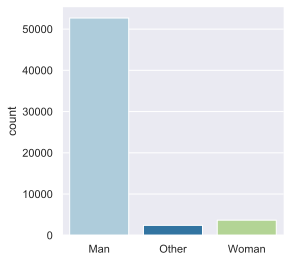

In [544]:
survey_dev['Gender'] = np.where(((survey_dev['Gender'] != 'Man') & (survey_dev['Gender'] != 'Woman')), 'Other', survey_dev['Gender'])

sns.catplot(x="Gender", kind="count", data=survey_dev,height = 4)
plt.xlabel("")

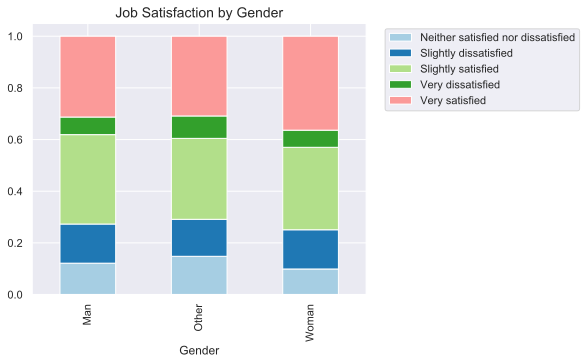

In [545]:
plotJobSatisfaction("Gender",6,5)
plt.title('Job Satisfaction by Gender',fontsize = 14);

Interestingly, there seems to be very **little difference in the distribution of job satisfaction** among genders. Women have replied "Very Satisfied" slightly more often (about 38% of all replies) than developers in the other categories (about 32%).

### Education

C:\Users\hissi\Anaconda3\lib\site-packages\matplotlib\textpath.py:90: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\hissi\Anaconda3\lib\site-packages\matplotlib\textpath.py:203: RuntimeWarning: Glyph 146 missing from current font.
  glyph = font.load_char(ccode, flags=LOAD_NO_HINTING)


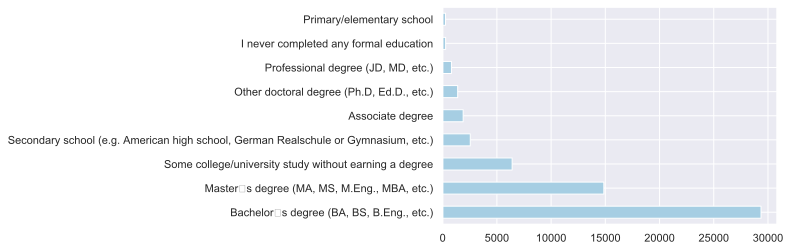

In [546]:
survey_dev['EdLevel'].value_counts().plot(kind='barh')

There's a column that I think contains a lot of interesting information: *EduOther*. The answers come from a multiple-choice question with the possibility of choosing more than one. This last factor complicates our analysis quite a lot.


The possible answers were:
- Taken an online course in programming or software development (e.g. a MOOC)
- Contributed to open source software (this information is already included in the *OpenSourcer* column, so I will ignore it)
- Taught yourself a new language, framework, or tool without taking a formal course
- Taken a part-time in-person course in programming or software development
- Participated in a hackathon
- Completed an industry certification program (e.g. MCPD)
- Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)

Even if it clearly cannot be used as it is, this column can still come in handy for us.
In particular, I would like to create a new **self-taught** category, that includes developers who meet ALL these conditions:
- don't have a STEM degree (most non-computer science STEM programs still have at least one programming course), except for health sciences majors
- didn't participate in a bootcamp or similar in-person programs

These conditions are pretty strict: I will still consider people who took online courses as self-taught.
I'm curious to see if this new feature will show any correlation to job satisfaction. The actual creation of the new feature will be in the next section of the article on *Feature Engineering*.

### Work-related

#### Job level

Unfortunately we don't have data on job levels (junior,senior, etc). The closest thing to that is the number of years spent coding as a professional, and the *MgrWant* column. The column contains the answer to "Would you like to become a manager some day?", and of course it includes the precious answer of those who are already managers.

Of course, a developer can be employed at a high level without being in a managerial position - think architects and other technical leads, but this is as close as we can get to the answer.


In [547]:
# New binary 'manager' column 
survey_dev = survey_dev.assign(Manager=0)
survey_dev['Manager'] = np.where( (survey_dev['MgrWant'].str.contains('manager')),1, survey_dev['Manager'])

In [548]:
survey_dev['Manager'].value_counts()

0    47083
1    11662
Name: Manager, dtype: int64

#### Working remote

(I have no idea what the "It's complicated" answer is supposed to mean)

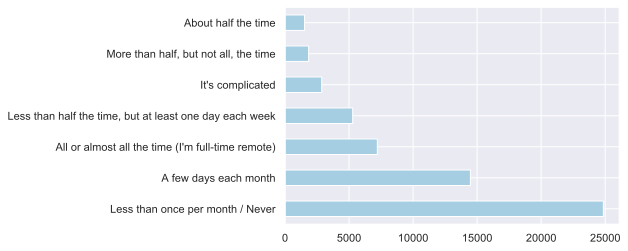

In [549]:
survey_dev['WorkRemote'].value_counts().plot(kind='barh')

#### Competence at work

We still haven't talked about the 'ImpSyn' column, which contains the answer to the question:

>For the specific work you do, and the years of experience you have, how do you rate your own level of competence?

I think competence is an interesting thing to look at in this context. Various influential writers (such as Robert Greene and Cal Newport) believe that job satisfaction doesn't come from innate passion, but rather from becoming very good at your craft, so if they are right we might see some correlation between these two variables.

Text(0, 0.5, 'Perceived competence at work')

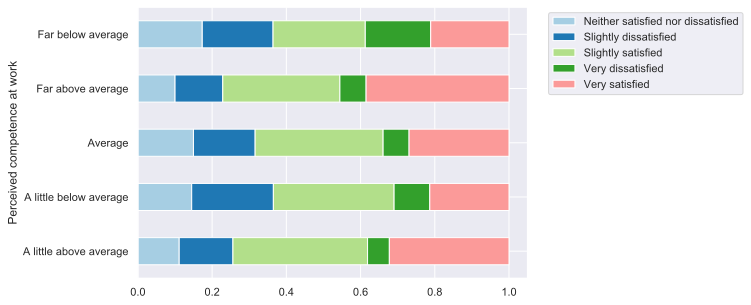

In [550]:
plotJobSatisfaction("ImpSyn", bartype = "barh", width = 7)
plt.ylabel("Perceived competence at work")
# The values are not properly ordered, it's annoying, I know.

There's definitely **something there**. Developers who perceive themselves as having below average abilites are measurably less satisfied in their work compared to their more competent (or at least more confident) colleagues. I will encode this as an ordinal numerical value later.

I think we're ready to choose the actual columns we will train our model on, and encode them in appropriate way if necessary. You will notice that I didn't analyse all the available columns, but this notebook was getting way too long.

Now it's feature engineering time!

## Feature engineering

### Field of study 

Another thing I wonder is whether people who work in the field that they studied for are more satisfied than others. For developers, The "relevant" majors to consider would be (as they appear in the *UndergradMajor* column):
- Web development or web design (front-end and full-stack developers)
- Computer science, computer engineering, or software engineering 
- Information systems, information technology, or system administration 

I will also consider the subcategory of people who work in data science and studied Mathematics/Statistics, since they are technically working in their study fields.

In [551]:
survey_dev = survey_dev.assign(SameField=0)
# Developers who have relevant majors
majors = ((survey_dev['UndergradMajor'].str.contains('web')) 
        |(survey_dev['UndergradMajor'].str.contains('computer'))
        | (survey_dev['UndergradMajor'].str.contains('information')) )
# Developers working in data 
data_scientist = ((survey_dev['DevType'].str.contains('Data scientist'))
                  & (survey_dev['UndergradMajor'].str.contains('statistics')))

survey_dev['SameField'] = np.where(majors, 1, survey_dev['SameField'])
survey_dev['SameField'] = np.where(data_scientist, 1, survey_dev['SameField'])


perc_dev = np.round(100*survey_dev['SameField'].sum()/len(survey_dev))
print(str(perc_dev)+'% of developers in the survey come from a computer science or data-related major.')


72.0% of developers in the survey come from a computer science or data-related major.


In [552]:
survey_dev[survey_dev['SameField'] == 1]['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          36162
Information systems, information technology, or system administration     3587
Web development or web design                                             2361
Mathematics or statistics                                                  416
Name: UndergradMajor, dtype: int64

### Remote work

The WorkRemote field has way too many values for my taste, so I'm going to refactor this column, since I still think it will be interesting to study it. I want to end up with three categories: *full-time remote, sometimes remote, not remote*.

I'm going to encode it with numbers, since that's what we would need to do later for the ML model anyway. The numbers will be in order of work-remoteness (new word right there), so 2: full-time, 1: part-time, 0: no time 😓


In [553]:
# new Remote column 
survey_dev = survey_dev.assign(Remote=0)

full_time = (survey_dev['WorkRemote'].str.contains('all or almost'))
part_time = ( (survey_dev['WorkRemote'].str.contains('week'))
          | (survey_dev['WorkRemote'].str.contains('half'))
             | (survey_dev['WorkRemote'].str.contains('few')) )

survey_dev['Remote'] = np.where(full_time, 2, survey_dev['Remote'])
survey_dev['Remote'] = np.where(part_time, 1, survey_dev['Remote'])

survey_dev['Remote'].value_counts()

0    34932
1    23128
2      685
Name: Remote, dtype: int64

Full-time remote developers are really rare, as I expected. Let's see about that job satisfaction.

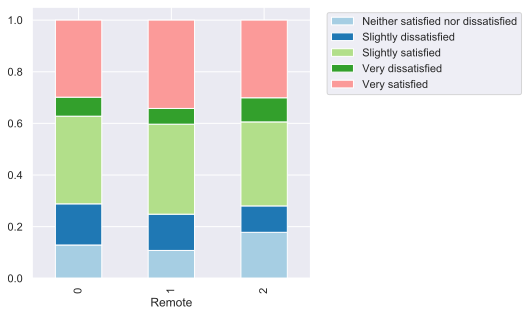

In [554]:
plotJobSatisfaction("Remote",5,5)

### Self-taught developers

In [555]:
survey_dev['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          36162
Another engineering discipline (ex. civil, electrical, mechanical)        4123
Information systems, information technology, or system administration     3587
Web development or web design                                             2361
A natural science (ex. biology, chemistry, physics)                       1928
Mathematics or statistics                                                 1899
A business discipline (ex. accounting, finance, marketing)                1022
A humanities discipline (ex. literature, history, philosophy)             1015
Fine arts or performing arts (ex. graphic design, music, studio art)       823
A social science (ex. anthropology, psychology, political science)         776
I never declared a major                                                   574
A health science (ex. nursing, pharmacy, radiology)                        126
Name: UndergradMajor, dtype: int64

In [556]:
not_self_taught = ((survey_dev['EduOther'].str.contains('bootcamp')) | (survey_dev['UndergradMajor'].str.contains('never'))
                        | (survey_dev['UndergradMajor'].str.contains('natural'))
                        | (survey_dev['UndergradMajor'].str.contains('computer'))
                        | (survey_dev['UndergradMajor'].str.contains('information'))
                        | (survey_dev['UndergradMajor'].str.contains('web'))
                        | (survey_dev['UndergradMajor'].str.contains('Mathematics'))
                        | (survey_dev['UndergradMajor'].str.contains('electrical')))


survey_dev = survey_dev.assign(SelfTaught=1)
survey_dev['SelfTaught'] = np.where(not_self_taught, 0, survey_dev['SelfTaught'])

In [557]:
survey_dev[survey_dev['SelfTaught'] == 1]['UndergradMajor'].value_counts()

A humanities discipline (ex. literature, history, philosophy)           761
A business discipline (ex. accounting, finance, marketing)              754
Fine arts or performing arts (ex. graphic design, music, studio art)    652
A social science (ex. anthropology, psychology, political science)      557
A health science (ex. nursing, pharmacy, radiology)                      89
I never declared a major                                                 26
Name: UndergradMajor, dtype: int64

We end up with about **6000 self-taught developers** according to our criteria.

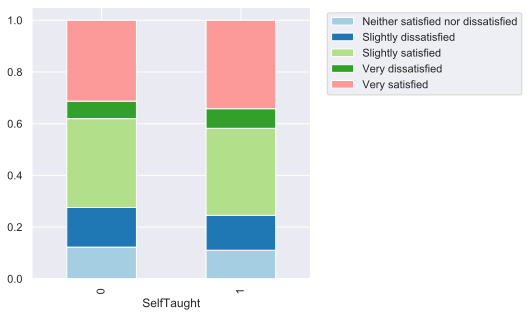

In [558]:
plotJobSatisfaction("SelfTaught",5,5)

Mmmm...seems like there's not much to see here. We will check this later when we build the model and measure relative feature importance.

### Ready for preprocessing

In [559]:
survey_pre =  survey_dev[['Hobbyist', 'Manager', 'Target', 'Remote', 'Gender', 'Country' , 'SelfTaught',
                         'WorkWeekHrs', 'OrgSize', 'Age', 'ImpSyn', 'SameField', 'YearsCode']]
# I'll drop rows with missing values, since they are not very numerous
survey_pre = survey_pre.dropna().reset_index()

In [560]:
survey_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49543 entries, 0 to 49542
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        49543 non-null  int64  
 1   Hobbyist     49543 non-null  object 
 2   Manager      49543 non-null  int64  
 3   Target       49543 non-null  float64
 4   Remote       49543 non-null  int64  
 5   Gender       49543 non-null  object 
 6   Country      49543 non-null  object 
 7   SelfTaught   49543 non-null  int64  
 8   WorkWeekHrs  49543 non-null  float64
 9   OrgSize      49543 non-null  object 
 10  Age          49543 non-null  float64
 11  ImpSyn       49543 non-null  object 
 12  SameField    49543 non-null  int64  
 13  YearsCode    49543 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 5.3+ MB


## Data pre-processing for machine learning

I will implement a pipeline using scikit-learn. The pipeline will perform different operations on different types of features, by using the **ColumnTransformer()** function. 
- For **ordinal features**, the pipeline will apply ordinal encoding to turn them into ordered numeric values. Then, these values will be scaled with a MinMaxScaler() so they are between 0 and 1.
- The other **numeric features** will be scaled as well (age, working hours and years spent coding), with the same function
- Finally, there's a remaining categorical feature, Gender, that will be one-hot-encoded

> **Note:** the target variable, JobSat, won't be modified in the pipeline.

### Why use scikit-learn's preprocessing functions

I will try to use scikit's learn preprocessing feature as much as possible, over Pandas' equivalent features. *Example*: OneHotEncoder() vs pd.get_dummies()

This provides two main advantages:
- you don't keep adding columns to your original DataFrame
- it makes the process more easily reproducible and easier to change. If you change your mind on how to encode a certain variable, in pandas you would have to remove the old column and make a new one. With scikit-learn, it's as easy ad modifying a step in the pipeline.

In [561]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [562]:
# ordinal features
orgsize = ['Just me - I am a freelancer, sole proprietor, etc.','2-9 employees',
          '10 to 19 employees','20 to 99 employees','100 to 499 employees',
          '500 to 999 employees','1,000 to 4,999 employees', '5,000 to 9,999 employees',  '10,000 or more employees']
imp_syn = ['Far below average','A little below average', 'Average', 'A little above average', 'Far above average']
ordinal_cat = [orgsize,  imp_syn]


In [563]:
survey_pre['YearsCode'] = np.where((survey_pre['YearsCode'] == 'Less than 1 year'), 0.5,survey_pre.YearsCode)
survey_pre['YearsCode'] = np.where((survey_pre['YearsCode'] == 'More than 50 years'), 50,survey_pre.YearsCode)

In [564]:

ordinal_features = ['OrgSize', 'ImpSyn']
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=ordinal_cat)),
     ('scaler', MinMaxScaler())])

numeric_features = ['Age', 'YearsCode', 'WorkWeekHrs']
numerical_transformer = StandardScaler()

categorical_features = ['Gender', 'Hobbyist']
# I only want to encode the US as a one-hot column from the Country column
onehot_cat = [['Woman', 'Man'],['Yes']]
categorical_transformer = OneHotEncoder(categories = onehot_cat ,handle_unknown='ignore')

# combining the two types of transformer with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
            #('target', OrdinalEncoder(categories = [jobsat]), ['JobSat']),
            ('num', numerical_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('ord', ordinal_transformer, ordinal_features)])

transformed_data = preprocessor.fit_transform(survey_pre)

In [565]:
categorical_transformer.fit(survey_pre[['Gender', 'Hobbyist']].values).get_feature_names()

array(['x0_Woman', 'x0_Man', 'x1_Yes'], dtype=object)

In [566]:
col_names = []
col_names.extend(numeric_features)
col_names.extend(['Woman', 'Man', 'Hobbyist'])
col_names.extend(ordinal_features)

>The order of the columns in the transformed feature matrix follows the order of how the columns are specified in the transformers list. Columns of the original feature matrix that are not specified are dropped from the resulting transformed feature matrix, unless specified in the passthrough keyword. 

That's great news, because we can simply create an array with the names of the columns in the order we have fed them to the transformer, and build a Dataframe using that array as header.
But let's not forget about the other features that we haven't touched yet, the ones we engineered! We'll need to concatenate them to the dataframe containing the preprocessed features.
Then we can finally move on to *splitting our dataset* in training, validation and test sets.

In [567]:
other_features = ['Target','Manager', 'Remote', 'SelfTaught', 'SameField']
data = pd.concat([pd.DataFrame(transformed_data, columns = col_names), survey_pre[other_features]],axis = 1)
data.head()

,Age,YearsCode,WorkWeekHrs,Woman,Man,Hobbyist,OrgSize,ImpSyn,Target,Manager,Remote,SelfTaught,SameField
0,-0.215926,0.311913,0.301399,0.0,1.0,1.0,1.00,0.75,0.0,0,1,0,1
1,1.280247,-0.839263,-0.263081,0.0,1.0,0.0,0.00,0.50,0.0,1,0,0,0
2,-1.088693,-0.148557,-0.263081,0.0,1.0,1.0,0.25,0.75,1.0,0,0,0,1
3,-0.465288,0.427030,-0.066740,0.0,1.0,1.0,0.25,0.75,1.0,1,0,0,1
4,-0.091245,-0.033440,-0.066740,0.0,1.0,1.0,0.50,0.75,1.0,0,0,0,1


In [568]:
X = data.drop(['Target'], axis =1)
y = data['Target'].astype('category')

In [569]:
y

0        0.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
49538    1.0
49539    1.0
49540    0.0
49541    0.0
49542    0.0
Name: Target, Length: 49543, dtype: category
Categories (2, float64): [0.0, 1.0]

In [570]:
X.head()

,Age,YearsCode,WorkWeekHrs,Woman,Man,Hobbyist,OrgSize,ImpSyn,Manager,Remote,SelfTaught,SameField
0,-0.215926,0.311913,0.301399,0.0,1.0,1.0,1.00,0.75,0,1,0,1
1,1.280247,-0.839263,-0.263081,0.0,1.0,0.0,0.00,0.50,1,0,0,0
2,-1.088693,-0.148557,-0.263081,0.0,1.0,1.0,0.25,0.75,0,0,0,1
3,-0.465288,0.427030,-0.066740,0.0,1.0,1.0,0.25,0.75,1,0,0,1
4,-0.091245,-0.033440,-0.066740,0.0,1.0,1.0,0.50,0.75,0,0,0,1


### Splitting the data

In [571]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [572]:
y


0        0.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
49538    1.0
49539    1.0
49540    0.0
49541    0.0
49542    0.0
Name: Target, Length: 49543, dtype: category
Categories (2, float64): [0.0, 1.0]

## Model training and tuning

In [573]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, f1_score
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

In [574]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 42)

In [575]:
rforest = RandomForestClassifier(random_state=42, max_depth = 7, criterion = 'entropy')
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[  64 4062]
 [  45 8215]]


In [576]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[ 386 3740]
 [ 456 7804]]


In [578]:
y_pred

array([1., 1., 1., ..., 1., 1., 0.])